In [1]:
import collections
import math
import os
import random
import zipfile
import urllib
import numpy as np
import tensorflow as tf

/home/zhangjialu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. 检查是否有数据集,如果没有在线下载

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _= urllib.request.urlretrieve(url+filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '.Can you get to it with a brower?')
    return filename

In [3]:
filename = maybe_download('text8.zip',31344016)

Found and verified text8.zip


### 2. 解压下载的文件,并用tf.compat.as_str转换为单词的列表

In [4]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        # zipfile.ZipFile(filename).read(name[, pwd])获取zip文档内指定文件的二进制数据。
        # zipfile.ZipFile(filename).namelist()获取zip文档内所有文件的名称列表
        # tf.compat.as_str将字节或 unicode 转换为 bytes，使用 UTF-8 编码进行文本处理
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()                  
    return data

In [5]:
words = read_data(filename)
print('Data size', len(words))

Data size 17005207


In [6]:
print(type(words))
print(words[:30])

<class 'list'>
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


### 3. 接下来创建vocabulary词汇表
+ 使用collections.Counter统计单词列表中单词的频数,使用most_common获取top50000的单词作为vocabulary
+ 创建一个字典,把top50000的词汇的vocabulary放入,以便快速查询,dic查询复杂度为O(1)
+ 将全部单词转换为一系列的编号,top50000之外的的编号为0
------------
一些数据类型
* count       [['UNK', 418391],('the', 1061396),('of', 593677),('and', 416629),('one', 411764),........]
* dictionary  {'UNK':0, 'the':1, 'of':2,.......}
* reverse_dictionary   {0:'UNK', 1:'the', 2:'of',.......}
* data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156,......] 按照words的词顺序,每个词的编号

In [8]:
vocabulary_size = 50000
def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1)) # extend() 函数用于在列表末尾一次性追加另一个序列中的多个值（用新列表扩展原来的列表）
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) # dictionary的键值互换
    return data, count, dictionary, reverse_dictionary
data, count, dictionary, reverse_dictionary = build_dataset(words)

In [9]:
del words # 删除原始单词列表,节约内存

In [23]:
print('Most common words (+UNK)', count[:5]) # 不按顺序的
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


### 4. 生成Word2Vec的训练样本
用Skip-Gram模式(从目标单词反推语境),将原始数据"the quick brown fox jumped over the lazy dog"转为(quick,the),(quick,brown),(brown,quick),(brown,fox)等样本
- batch_size: batch大小
- num_skips: 对每个单词生成多少样本,他不能大于skip_window的两倍,并且batch_size必须是他的整数倍,确保包含所有的样本
- skip_window: 单词最远可以联系的距离
- span为对某个单词创建相关样本时会使用到的单词数量,包括目标单词本身和他前后的单词,因此,span=2*skip_window+1

In [24]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span) # 最大容量为span的双向队列,在对deque使用append方法添加变量时,只会保留最后插入的span个变量
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

测试generate_batch的功能:
- 以第一个样本为例,3081为originated的编号,这个单词对应的语境是anarchism,anarchism的编号是5234

In [25]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i,0], reverse_dictionary[labels[i,0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 6 a
12 as -> 3081 originated
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


In [26]:
len(batch)

8

设置训练时的参数:

In [29]:
batch_size = 128
embedding_size = 128 # 词向量的维度
skip_window = 1
num_skips = 2

valid_size = 16 # 用来抽取的验证单词数
valid_window = 100 # 验证单词只从频数最高的valid_window个里来选
valid_examples = np.random.choice(valid_window, valid_size, replace=False) # 随机抽取的频数高的一些单词
num_sampled = 64 # 训练时用来做负样本的噪声单词数量

### 5. 定义Skip-Gram Word2Vec模型的网络结构
- NCE Loss(Noise-Contrastive Estimation)

In [30]:
graph = tf.Graph()        # 创建一个tf.Graph
with graph.as_default():  # 设置为默认Graph
    # 输入接口
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)   # 将前面产生的valid_examples转为tensorflow中的constant

    with tf.device('/cpu:0'):     # 限定所有计算在CPU上操作,应为以下一些操作在GPU上可能还没实现
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) # 用tf.random_uniform随机生成50000个词,128维度的词向量
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)   # tf.nn.embedding_lookup查找train_inputs对应的embeddings

    # 构造NCE loss的变量
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], 
                            stddev=1.0 / math.sqrt(embedding_size)))  # tf.truncated_normal初始化NCE loss中的权重参数nce_weights
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))   #  nce_biases初始化为零

    # 计算一个batch的平均NCE loss
    # tf.nce_loss自动提取(draw)每个负标签的新样本
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))

    # 构造梯度下降算法优化器,学习率设为1
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))  # 计算嵌入向量embeddings的L2范数
    normalized_embeddings = embeddings / norm  # 再将embeddings除以其L2范数得到标准化后的normalized_embeddings
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)  # tf.nn.embedding_lookup查询验证单词的嵌入向量
    # 计算验证单词的嵌入向量与词汇表中所有单词的相似性
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    init = tf.global_variables_initializer() # 初始化所有模型变量参数

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### 6. 开始训练模型

In [33]:
num_steps = 100001  # 定义最大迭代次数为100000次

with tf.Session(graph=graph) as session:      # 创建并设置默认的session
    init.run()   # 在使用session之前,初始化所有模型变量参数
    print("Initialized")

    average_loss = 0
    for step in range(num_steps):
        # 在每一步迭代中先使用generate_batch生成一个batch的inputs和labels
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)    
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels} # 然后把他们送入到输入中

        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict) # 执行一次优化器运算(即一次参数更新)和损失运算
        average_loss += loss_val # 将loss累计到average_loss
        
        # 之后每2000次循环一次,计算平均loss并显示出来
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # 每10000次循环,计算一次验证单词与全部单词的相似度,并将与每个验证单词最相似的8个单词展现出来
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  255.71640014648438
Nearest to state: escaped, delicate, approximations, tongue, car, qd, eats, tegmark,
Nearest to when: unwise, overestimated, juncture, nan, erowid, farmers, kick, kt,
Nearest to during: encountered, resignation, mvp, christos, woolwich, steamships, capitan, disorders,
Nearest to see: matrices, ul, insane, barkley, dreadnoughts, onager, parsecs, flops,
Nearest to in: trombone, serrano, stinging, remastered, obrzeg, freire, gentlemen, burrows,
Nearest to history: carats, rosalind, barrett, dunk, breakdowns, honors, fills, lucan,
Nearest to who: snark, boils, davidian, aladdin, protects, dao, hermes, enchanted,
Nearest to time: shawar, ads, liddell, fiji, plato, infinitum, russo, enormous,
Nearest to for: morale, tank, gamelan, phocas, eval, minardi, dvorak, magnentius,
Nearest to from: xa, dessert, responded, confessing, causeway, silver, skid, trendy,
Nearest to between: hypothesized, viacom, winding, congestion, openbsd, poisono

Average loss at step  52000 :  5.213460727572441
Average loss at step  54000 :  5.059558549761772
Average loss at step  56000 :  5.073866256117821
Average loss at step  58000 :  4.833078347802163
Average loss at step  60000 :  4.929507144331932
Nearest to state: escaped, arctocephalus, neutronic, tongue, car, delicate, approximations, deprived,
Nearest to when: if, while, five, was, and, six, after, at,
Nearest to during: in, at, on, following, after, sisters, yang, tora,
Nearest to see: flops, ul, stadtbahn, mvs, imine, and, zilog, explaining,
Nearest to in: on, at, during, and, eight, from, of, since,
Nearest to history: mecca, scoping, stadtbahn, arctocephalus, quagga, tetra, modula, wp,
Nearest to who: he, which, and, she, they, it, there, also,
Nearest to time: ads, eml, quagga, fiji, modula, maja, cadet, barb,
Nearest to for: with, of, quagga, without, and, in, datura, or,
Nearest to from: in, into, and, by, through, after, at, mvs,
Nearest to between: with, inuit, hypothesized, 

### 7. 可视化Word2Vec词向量

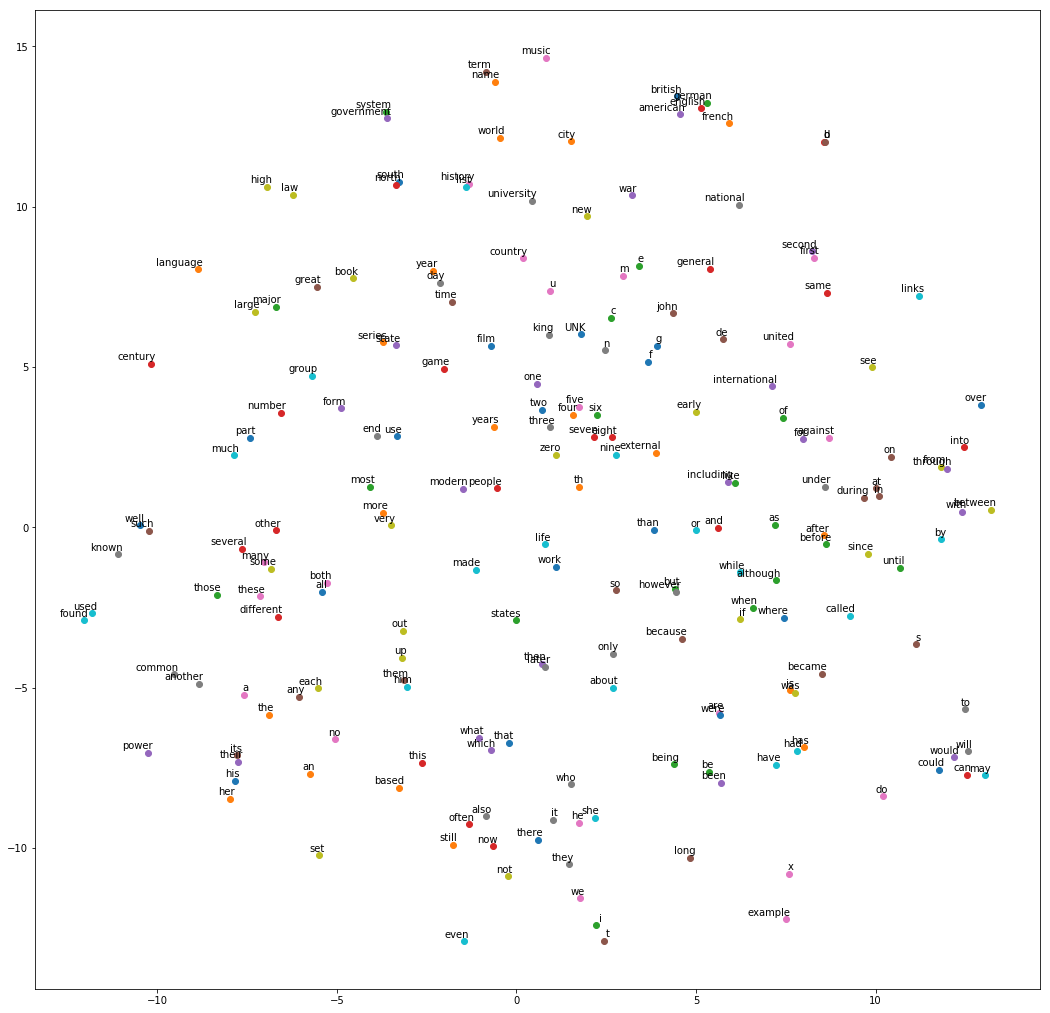

In [34]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)             # 显示散点图
        plt.annotate(label,
                    xy=(x, y),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')      #展示单词本身

    plt.savefig(filename)

#%%
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)  # 降维,降到2维
    plot_only = 200 # 显示词频最高的200个词
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
    labels = [reverse_dictionary[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")